# Plot the particle motions of high-Q gliders in a time window at the location of each station

In [8]:
# Imports
from pandas import Timestamp, Timedelta
from matplotlib.pyplot import figure, subplots
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator
from matplotlib.dates import DateFormatter
from numpy import geomspace, column_stack

from utils_basic import get_geophone_locs, get_unique_stations, time2filename
from utils_basic import EASTMIN_WHOLE as eastmin, EASTMAX_WHOLE as eastmax, NORTHMIN_WHOLE as northmin, NORTHMAX_WHOLE as northmax, ROOTDIR_GEO as rootdir
from utils_preproc import read_and_process_windowed_geo_waveforms
from utils_wavelet import get_scales_and_freqs, get_stream_cwt
from utils_pol import get_pol_vidale
from utils_plot import component_to_label, format_utc_xlabels, format_freq_ylabels, save_figure

In [9]:
# Inputs
## Data
station_cwt = "A05"
component_cwt = "Z"
starttime_cwt = Timestamp("2020-01-13T20:01:01.5Z")
dur_cwt = 10.0

## Preprocessing
min_freq_filt = 40.0
max_freq_filt = 75.0

deci_factor = 2 # Decimation factor

## Particle motion
starttime_pm = Timestamp("2020-01-13T20:01:05Z")
dur_pm = 2.5

## Wavelet transform
wavelet = "cmor"
bandwidth = 20.0
center_freq = 2.0
min_scales = 5
max_sacale = 50
num_scales = 128

## Plotting
stations_to_skip = ["A12", "A18"]
stations_label_top_right = []
stations_label_bottom_left = ["A05", "A15", "A19", "B16", "B20"]

scale_fig = 10.0
scale_pm = 10.0

linewidth_pm = 0.1
linewidth_window = 2.0

max_freq_plot = 75.0
min_freq_plot = 40.0

dbmin = 0.0
dbmax = 45.0

hw_ratio_spec = 0.15 # Height-width ratio of the spectrogram plot

major_time_spacing = 5.0
minor_time_spacing = 1.0

major_freq_spacing = 10.0
minor_freq_spacing = 2.0

axis_label_size = 12
tick_label_size = 10

In [10]:
# Read the station coordinates
sta_df = get_geophone_locs()
sta_df = sta_df[~sta_df["name"].isin(stations_to_skip)]


In [11]:
# Read and process the data
stream_cwt = read_and_process_windowed_geo_waveforms(starttime_cwt, dur_cwt, stations=station_cwt, components=component_cwt, freqmin=min_freq_filt, freqmax=max_freq_filt, normalize=True, decimate=True, decimate_factor=deci_factor, all_components=False)
stream_pm = read_and_process_windowed_geo_waveforms(starttime_pm, dur_pm, components=["1", "2"], freqmin=min_freq_filt, freqmax=max_freq_filt, normalize=True, decimate=True, decimate_factor=deci_factor)

In [12]:
# Compute the CWT
scales, freqs = get_scales_and_freqs(wavelet, center_freq, bandwidth, min_scales, max_sacale, num_scales)
specs = get_stream_cwt(stream_cwt, wavelet=wavelet, bandwidth=bandwidth, center_freq=center_freq, scales=scales)
spec = specs[0]

In [13]:
# Get the PM data
pm_dict = {}
stations_pm = get_unique_stations(stream_pm)

for station in stations_pm:
    data_1 = stream_pm.select(station=station, component="1")[0].data
    data_2 = stream_pm.select(station=station, component="2")[0].data
    pm_dict[station] = column_stack((data_2, data_1))

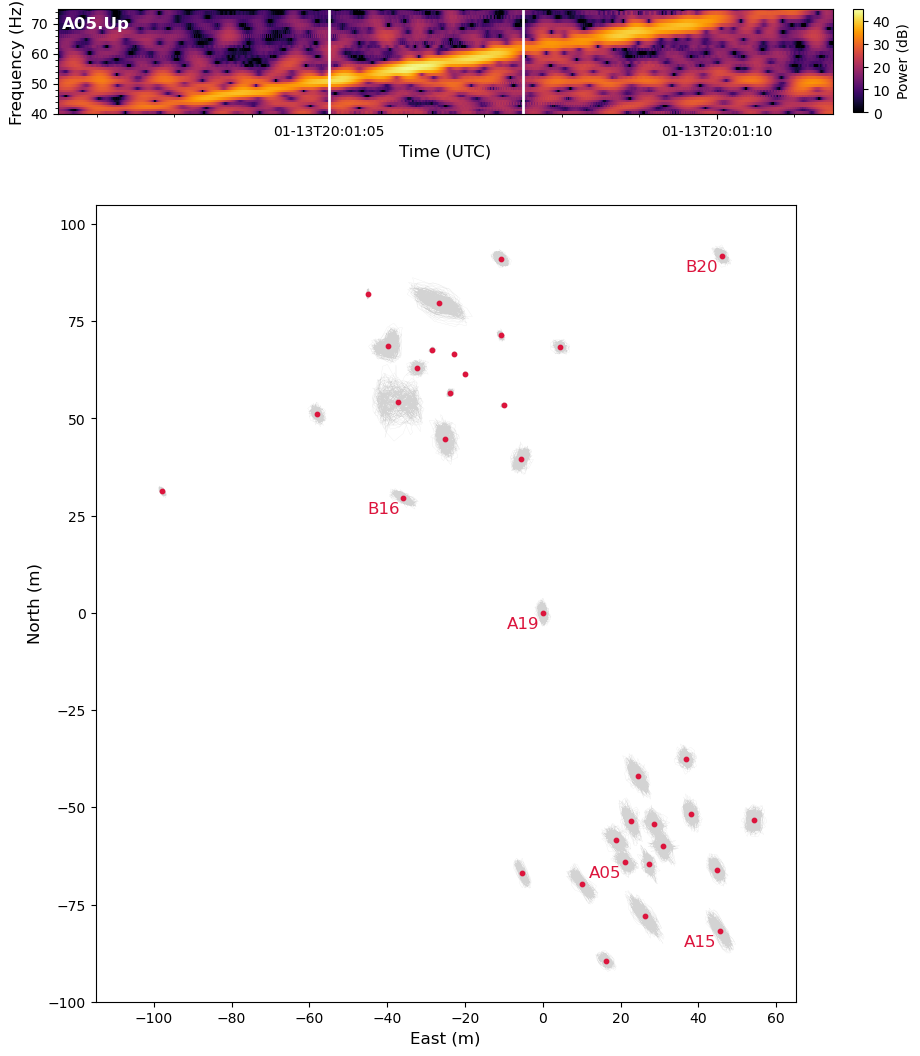

In [14]:
# Plotting

## Compute the dimensions of the figure
hw_ratio_map = (northmax - northmin) / (eastmax - eastmin)
hw_ratio_fig = hw_ratio_map + hw_ratio_spec

height_fig = scale_fig * hw_ratio_fig
width_fig = scale_fig

## Generate the subplots with the correct dimensions
fig = figure(figsize=(width_fig, height_fig))
gs = GridSpec(2, 1, height_ratios=[hw_ratio_spec, hw_ratio_map])

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

## Plot the spectrogram
power = spec.get_power()
times = spec.times
freqs = spec.freqs

power_color = ax1.pcolormesh(times, freqs, power, cmap="inferno", shading="auto", vmin=dbmin, vmax=dbmax)
ax1.axvline(starttime_pm, color="white", linewidth=linewidth_window, zorder=2)
ax1.axvline(starttime_pm + Timedelta(seconds=dur_pm), color="white", linewidth=linewidth_window, zorder=2)

ax1.text(0.005, 0.93, f"{station_cwt}.{component_to_label(component_cwt)}", transform=ax1.transAxes, color="white", fontsize=12, fontweight="bold", va="top", ha="left")

ax1.set_ylim(min_freq_plot, max_freq_plot)

format_utc_xlabels(ax1, axis_label_size=axis_label_size, tick_label_size=tick_label_size, major_tick_spacing=major_time_spacing, minor_tick_spacing=minor_time_spacing)
format_freq_ylabels(ax1, axis_label_size=axis_label_size, tick_label_size=tick_label_size, major_tick_spacing=major_freq_spacing, minor_tick_spacing=minor_freq_spacing)

## Add the colorbar
cax = fig.add_axes([0.92, 0.8, 0.01, 0.08])
cbar = fig.colorbar(power_color, cax=cax, label="Power (dB)")
cbar.locator = MultipleLocator(10)
cbar.update_ticks()

## Plot the particle motions
for station, pm_data in pm_dict.items():    
    east = sta_df.loc[sta_df["name"] == station, "east"].values[0]
    north = sta_df.loc[sta_df["name"] == station, "north"].values[0]

    pm_data_east = pm_data[:, 0] * scale_pm + east
    pm_data_north = pm_data[:, 1] * scale_pm + north

    ax2.plot(pm_data_east, pm_data_north, color="lightgray", linewidth=linewidth_pm, zorder=0)

easts = sta_df["east"]
norths = sta_df["north"]
ax2.scatter(easts, norths, s=10, color="crimson", marker="o", zorder=1)

for station in stations_label_top_right:
    east = sta_df.loc[sta_df["name"] == station, "east"].values[0]
    north = sta_df.loc[sta_df["name"] == station, "north"].values[0]

    ax2.annotate(station, (east, north), textcoords="offset points", xytext=(2.5, 2.3), color="crimson", fontsize=12, va="bottom", ha="left")

for station in stations_label_bottom_left:
    east = sta_df.loc[sta_df["name"] == station, "east"].values[0]
    north = sta_df.loc[sta_df["name"] == station, "north"].values[0]

    ax2.annotate(station, (east, north), textcoords="offset points", xytext=(-2.5, -2.5), color="crimson", fontsize=12, va="top", ha="right")

# for station in stations_label_bottom_center:
#     east = sta_df.loc[sta_df["name"] == station, "east"].values[0]
#     north = sta_df.loc[sta_df["name"] == station, "north"].values[0]

#     ax2.annotate(station, (east, north), textcoords="offset points", xytext=(0, -5), color="crimson", fontsize=10)

# for station in stations_label_top_center:
#     east = sta_df.loc[sta_df["name"] == station, "east"].values[0]
#     north = sta_df.loc[sta_df["name"] == station, "north"].values[0]

    # ax2.annotate(station, (east, north), textcoords="offset points", xytext=(0, 5), color="crimson", fontsize=10)

ax2.set_xlim(eastmin, eastmax)
ax2.set_ylim(northmin, northmax)

ax2.set_xlabel("East (m)", fontsize=axis_label_size)
ax2.set_ylabel("North (m)", fontsize=axis_label_size)

ax2.tick_params(axis="both", which="major", labelsize=tick_label_size)

ax2.set_aspect("equal")



In [15]:
# Save the figure
timestr = time2filename(starttime_cwt)
figname = f"high_q_glider_pm_map_{timestr}.png"
save_figure(fig, figname, outdir=rootdir)


Figure saved to /Volumes/OmanData/data/geophones/high_q_glider_pm_map_20200113T200101.png
